In [1]:
%run "subhead.ipynb"

In [2]:
import pandas as pd
from cooler import Cooler
from hic_basic.coolstuff import cli_IS, cli_balance
from hic_basic.plot.hic import plot_IS

In [3]:
batches = ["Sperm_hg_gam_MR15_ft4", "Sperm_hg_50k","Rao2014_50k"]
#batches = ["Sperm", "Rao2014", "Bonev2017", "GMbulk", "mESCbulk"]

IS_args = {
    "Sperm_hg_gam_MR15_ft4": {
        "coolp" : str(h.ddir / "Sperm_hg.MR15.fthres__4.50k.cool"),
        "output" : h.ddir / "Sperm_gam_MR15_ft4.IS.tsv",
        "windowsizes" : [250000, 500000, 1000000],
        "balanced" : False
    },
    "Sperm_hg_50k" :  {
        "coolp" : str(h.ddir / "Sperm_hg.pileup.1k.mcool::resolutions/50000"),
        "output" : h.ddir / "Sperm_hg_50k.IS.tsv",
        "windowsizes" : [250000, 500000, 1000000],
        "balanced" : False
    },
    "Rao2014_50k" : {
        "coolp" : "/share/Data/ychi/raw/Rao2014/4DN_cooler/GM12878.n.mcool::resolutions/50000",
        "output" : h.ddir / "Rao2014_50k.IS.tsv",
        "windowsizes" : [250000, 500000, 1000000],
        "balanced" : False
    },
}

genomes = {
    "Sperm_hg_gam_MR15_ft4": "GRCh38",
    "Sperm_hg_50k" : "GRCh38",
    "Rao2014_50k" : "GRCh38",
}

coolps = {
    "Sperm_hg_gam_MR15_ft4": str(h.ddir / "Sperm_hg.MR15.fthres__4.50k.cool"),
    "Sperm_hg_50k" : str(h.ddir / "Sperm_hg.pileup.1k.mcool::resolutions/50000"),
    "Rao2014_50k" : "/share/Data/ychi/raw/Rao2014/4DN_cooler/GM12878.n.mcool::resolutions/50000",
}

Balanced matrix 'weight' already exists. Skipping execution.


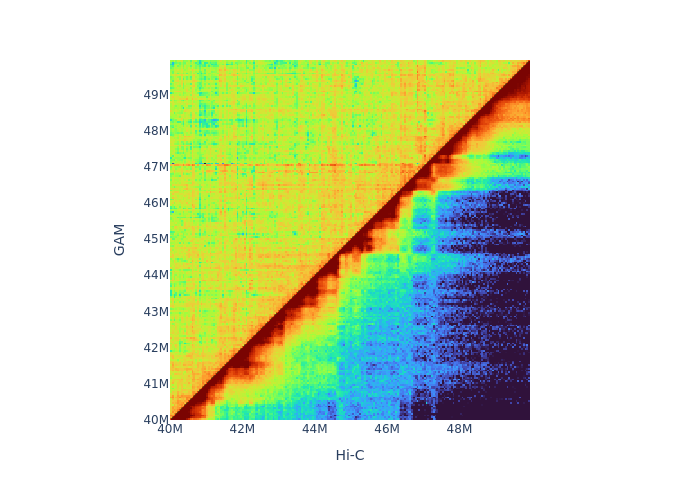

In [6]:
from hic_basic.coolstuff import cli_balance
cli_balance(coolps["Rao2014_50k"])

region = "chr1:40,000,000-50,000,000"
hic_file = coolps["Rao2014_50k"]
gam_file = coolps["Sperm_hg_gam_MR15_ft4"]
fig = plot_tilling_gam_hic(hic_file, gam_file, region, add_xy=True, gam_kwargs={"zmax":1.2})
fig.show(renderer="png")

In [17]:
from pathlib import Path

In [18]:
cli_balance(coolps["Sperm_hg_50k"])

Fin = False
if not Fin:
    for batch in batches:
        if not Path(IS_args[batch]["output"]).exists():
            cli_IS(IS_args[batch]["coolp"], IS_args[batch]["output"], IS_args[batch]["windowsizes"],
                balanced = IS_args[batch]["balanced"]
                )

Balanced matrix 'weight' already exists. Skipping execution.


In [19]:
from hic_basic.genome import Region

In [9]:
from hic_basic.genome import Region
from hic_basic.plot.hic import _add_IS_track, merge_track_data
def plot_tilling_gam_hic_ISs(hic_file, gam_file, hic_IS_file, gam_IS_file, region, genome,
    hic_balance = True,
    IS_col="log2_insulation_score_1000000",
    title="", IS_y_kwargs={}, gam_kwargs={}, hic_kwargs={}):
    fig = make_subplots(
        rows=3,
        cols=1,
        shared_xaxes=True,
        row_heights=[10, 1, 1],
        vertical_spacing=0.02
    )
    # --- add tiling compartment --- #
    img_mat = plot_tilling_gam_hic(
        hic_file, gam_file, region,
        hic_balance=hic_balance,
        gam_kwargs=gam_kwargs, hic_kwargs=hic_kwargs
        )
    fig.add_trace(
        img_mat.data[0]
    )
    fig.update_xaxes(
        title = "",
        row=1,
        col=1
    )
    fig.update_yaxes(
        title = "",
        autorange = True, # vital! Otherwise, the heatmap willbe upside down
        visible = False,
        row=1,
        col=1
    )
    # --- add IS tracks --- #
    r = Region(region).r
    gam_IS = pd.read_table(
        gam_IS_file, index_col=["chrom","start"]
        ).sort_index().loc[r[0]:r[1]].reset_index()
    hic_IS = pd.read_table(
        hic_IS_file, index_col=["chrom","start"]
        ).sort_index().loc[r[0]:r[1]].reset_index()
    data = {
        "GAM" : gam_IS,
        "HiC" : hic_IS
    }
    for row, col, i, feature in filling_l2r_plotly(2, 1, features=["GAM","HiC"]):
        data_type = feature
        fig = _add_IS_track(
            fig, data[data_type], IS_col,
            row=row+1, # under the heatmap
            col=col,
            y_kwargs = IS_y_kwargs
            )
    fig.update_layout(
        height = 600,
        width = 500,
        title = title,
        plot_bgcolor = "rgba(0,0,0,0)",
    )
    #fig.update_yaxes(visible=False)
    return fig

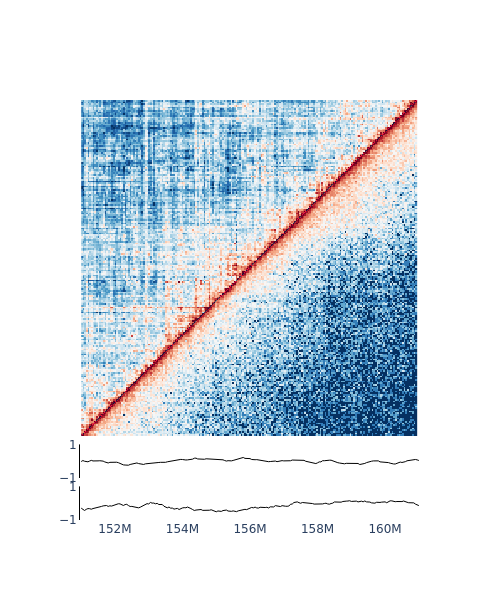

In [52]:
region = "chr1:151,000,000-161,000,000"
genome = "GRCh38"
hic_batch = "Sperm_hg_50k"
gam_batch = "Sperm_hg_gam_MR15_ft4"
hic_file = IS_args["Sperm_hg_50k"]["coolp"]
gam_file = IS_args["Sperm_hg_gam_MR15_ft4"]["coolp"]
hic_balance = False
fig = plot_tilling_gam_hic_ISs(
    hic_file, gam_file,
    IS_args[hic_batch]["output"],IS_args[gam_batch]["output"],
    region, genome, hic_balance = hic_balance,
    IS_col = "log2_insulation_score_500000",
    IS_y_kwargs = dict(
        range = [-1,1],
        tickvals = [-1,1]
    ),
    hic_kwargs = dict(
        cmap = "RdBu_r",
        donorm = True,
        range_for_balance = False,
        zmax = 0.85,
        zmin = 0
    ),
    gam_kwargs = dict(
        cmap = "RdBu_r",
        donorm = False,
        range_for_balance = False,
        zmax = 0.75, # 0.1,0.8
        zmin = 0.1,
    )
)
fig.update_layout(
    showlegend = False
)
fig.show(renderer="png")
fig.write_image(
    get_fig_outprefix() + "human_sperm_gam_hic_ISs.pdf"
)

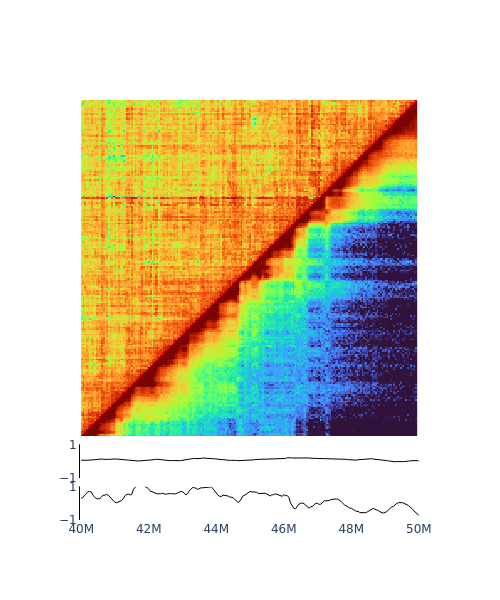

In [15]:
region = "chr1:40,000,000-50,000,000"
hic_batch = "Rao2014_50k"
gam_batch = "Sperm_hg_gam_MR15_ft4"
hic_file = coolps[hic_batch]
gam_file = coolps[gam_batch]
fig = plot_tilling_gam_hic_ISs(
    hic_file, gam_file,
    IS_args[hic_batch]["output"],IS_args[gam_batch]["output"],
    region,
    IS_y_kwargs = dict(
        range = [-1,1],
        tickvals = [-1,1]
    ),
    gam_kwargs = dict(
        zmax = 1,
        zmin = 0
    )
)
fig.update_layout(
    showlegend = False
)
fig.show(renderer="png")